# Data driven business decision making

## Description of the project
### Description of data

**Data for the first part**

*File /datasets/hypothesis.csv.*
* Hypothesis - a brief description of the hypothesis;
* Reach - user coverage on a 10-point scale;
* Impact - impact on users on a 10-point scale;
* Confidence - confidence in the hypothesis on a 10-point scale;
* Efforts - the cost of resources to test the hypothesis on a 10-point scale. The larger the Efforts value, the more expensive it is to test the hypothesis.

**Data for the second part**

*File /datasets/orders.csv.*
* transactionId - order identifier;
* visitorId - ID of the user who made the order;
* date - the date when the order was made;
* revenue — order revenue;
* group — the A/B test group that the order belongs to.

*File /datasets/visitors.csv.*
* date — date;
* group — A/B test group;
* visitors — number of users on the specified date in the specified A/B test group

#### Context
***We are analysts of a large online store. Together with the marketing department, you have prepared a list of hypotheses for increasing revenue.***

<a name="1common."></a>
## <a name="0.0"></a>Content:
* [Loading libraries and self-written functions](#0.)
* [Loading data](#01.)
* [Hypothesis Prioritization](#1.)
* [A/B Test Analysis](#2.)
* [Decision based on test results](#3.)

## Loading libraries and self-written functions
<a name="0."></a>
[<font size="2">(to content)</font>](#1common.)

In [52]:
# обновим до последней версии чтобы питон не ругался на графики
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /Users/lesia/opt/anaconda3/lib/python3.7/site-packages (0.11.2)


In [53]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

import scipy.stats as stats
import datetime as dt

In [54]:
sns.set_theme(style="white", context="talk")

In [55]:
pd.options.display.max_colwidth = 120

In [56]:
#Define the bold
def bold():
    return "\033[1m"

def bold_end():
    return "\033[0m"

#Set the format for numbers
pd.options.display.float_format = '{:>10.2f}'.format

In [57]:
#**Function print_basic_info, to display information about the array and its variables.**

def print_basic_info(base, info, describe, duplicate, head_tail):
    
    '''
    #* base - database name
    #* info - 1: output information about the array, other: no output
    #* describe - 1: output description of array variables, other: no output
    #* duplicat - 1: print the number of full duplicates
    #* head - n: base example output (output n - lines), n < 1: no output    
    '''

    
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print(base.info())
    if head_tail >= 1:
        print("\n", bold(),colored('head_tail','green'),bold_end())
        display(base.head(head_tail).append(base.tail(head_tail)))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicate == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())

## Загрузка данных
<a name="01."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [58]:
#load
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',',decimal='.')
    orders = pd.read_csv('/datasets/orders.csv', sep=',',decimal='.')
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',',decimal='.')
except:
    hypothesis = pd.read_csv('datasets/hypothesis.csv', sep=',',decimal='.')
    orders = pd.read_csv('datasets/orders.csv', sep=',',decimal='.')
    visitors = pd.read_csv('datasets/visitors.csv', sep=',',decimal='.')


In [59]:
print_basic_info(hypothesis,1,0,0,4)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

  head_tail 


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


* Totaly 9 hypotheses
* There are no gaps in the filling and no duplicates.

In [60]:
print_basic_info(orders,1,1,1,4)

#unique key
print("\n", bold(),colored('unique transactionId','green'),bold_end(),"\n")
print(len(orders['transactionId'].unique()))

#unique key
print("\n", bold(),colored('unique visitorId','green'),bold_end(),"\n")
print(len(orders['visitorId'].unique()))


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

  head_tail 


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A
1196,3936777065,2108080724,2019-08-15,202740,B



  describe  


  transactionId  
 count         1197.00
mean    2155621385.53
std     1229084904.76
min        1062393.00
25%     1166775572.00
50%     2145193898.00
75%     3237740112.00
max     4293855558.00
Name: transactionId, dtype: float64

  visitorId  
 count         1197.00
mean    2165960143.10
std     1236014192.15
min        5114589.00
25%     1111826046.00
50%     2217984702.00
75%     3177606451.00
max     4283872382.00
Name: visitorId, dtype: float64

  date  
 count           1197
unique            31
top       2019-08-05
freq              48
Name: date, dtype: object

  revenue  
 count      1197.00
mean       8348.01
std       39191.13
min          50.00
25%        1220.00
50%        2978.00
75%        8290.00
max     1294500.00
Name: revenue, dtype: float64

  group  
 count     1197
unique       2
top          B
freq       640
Name: group, dtype: object

  duplicated  

0

  unique transactionId  

1197

  unique visitorId  

1031


* Total 1197 transactions from 1031 users. So there were several transactions.
* Total 2 groups in the test.

In [61]:
print_basic_info(visitors,1,1,1,4)

print("\n", bold(),colored('unique date','green'),bold_end(),"\n")
print(len(visitors['date'].unique()))


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None

  head_tail 


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718



  describe  


  date  
 count             62
unique            31
top       2019-08-01
freq               2
Name: date, dtype: object

  group  
 count     62
unique     2
top        A
freq      31
Name: group, dtype: object

  visitors  
 count        62.00
mean        607.29
std         114.40
min         361.00
25%         534.00
50%         624.50
75%         710.50
max         770.00
Name: visitors, dtype: float64

  duplicated  

0

  unique date  

31


* Total 62 lines. 31 days for each group

In [62]:
# dates format
orders['date'] = orders['date'].astype('datetime64') 
visitors['date'] = visitors['date'].astype('datetime64')

#### Checking orders data for adequacy

In [63]:
#in both groups
def in_both(first, second):
    return [item for item in first if item in second]

list_bad_visitorid  = in_both(orders.query("group == 'A'")['visitorId'].unique()
                              , orders.query("group == 'B'")['visitorId'].unique())
len(list_bad_visitorid)

58

In [64]:
# del them

print(len(orders))

orders  = orders[np.logical_not(orders['visitorId'].isin(list_bad_visitorid))]

print(len(orders))

1197
1016


In [65]:
#cheсk
list_bad_visitorid  = in_both(orders.query("group == 'A'")['visitorId'].unique()
                              , orders.query("group == 'B'")['visitorId'].unique())
len(list_bad_visitorid)

0

## Prioritization of hypotheses
<a name="1."></a>
[<font size="2">(to content)</font>](#1common.)

9 hypotheses for increasing the revenue of an online store with the specified parameters Reach, Impact, Confidence, Effort.

#### An ICE framework for prioritizing hypotheses.

In [66]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence'] ) / hypothesis['Efforts']
 
hypothesis['Rank_ICE'] = hypothesis['ICE'].rank(method='first', ascending=False)
hypothesis = hypothesis.sort_values(by='ICE', ascending=False)
hypothesis[['Hypothesis', 'ICE','Rank_ICE']]

,Hypothesis,ICE,Rank_ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,1.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,2.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,3.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,4.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,5.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,6.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,7.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,8.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,9.00


In [67]:

hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)['Hypothesis'].values[0:5]

array(['Запустить акцию, дающую скидку на товар в день рождения',
       'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа'],
      dtype=object)

#### Фреймворк RICE для приоритизации гипотез.

In [68]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
    
hypothesis['Rank_RICE'] = hypothesis['RICE'].rank(method='first', ascending=False)
hypothesis = hypothesis.sort_values(by='RICE', ascending=False)
hypothesis[['Hypothesis', 'RICE','Rank_RICE']]


,Hypothesis,RICE,Rank_RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00,1.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00,2.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00,3.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00,4.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,5.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00,6.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00,7.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00,8.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00,9.00


In [69]:

hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)['Hypothesis'].values[0:5]


array(['Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

#### Как изменилась приоритизация гипотез при применении RICE вместо ICE.

In [70]:
hypothesis[['Hypothesis', 'Reach', 'Rank_ICE','Rank_RICE']]

,Hypothesis,Reach,Rank_ICE,Rank_RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,3.00,1.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,5.00,2.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,2.00,3.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,4.00,4.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,1.00,5.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,8.00,6.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,6.00,7.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,7.00,8.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,9.00,9.00


The difference in prioritization of hypotheses is related to the Reach score. Namely, what percentage of the audience is involved in these changes.

Therefore, it is quite logical that the birthday promotion (i.e. interaction with one client once a year) has decreased its position.
and collecting a customer base for email newsletters (i.e. a new channel of endless interaction) has significantly increased its own.

## A/B test analysis
<a name="2."></a>
[<font size="2">(to content)</font>](#1common.)

You ran an A/B test and got the results described in the orders.csv and visitors.csv files.

#### Graph of cumulative revenue by groups.

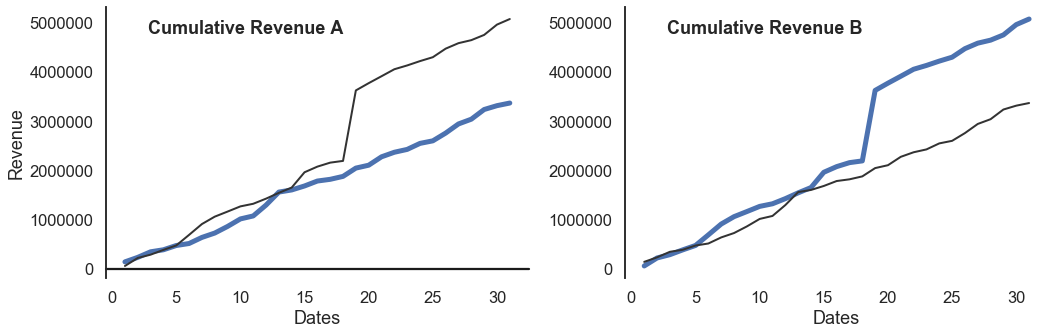

In [71]:
output = orders.pivot_table(
    index='date', columns='group', values='revenue', aggfunc='sum'
)
output.index = (output.index.astype('str').str[-2:]).astype('int')

f, (ax1, ax2)=plt.subplots(1, 2, figsize=(15, 5), sharex=True)
#A
ax1.text(.1, .90, "Cumulative Revenue A", transform=ax1.transAxes, fontweight="bold")
sns.lineplot(data=output.cumsum(axis = 0), x=output.cumsum(axis = 0).index, y="A",
             estimator=None,palette="crest", linewidth=5, ax=ax1)
sns.lineplot(data=output.cumsum(axis = 0), x=output.cumsum(axis = 0).index, y="B",
             estimator=None, color=".2", linewidth=2, ax=ax1)

#B
ax2.text(.1, .90, "Cumulative Revenue B", transform=ax2.transAxes, fontweight="bold")
sns.lineplot(data=output.cumsum(axis = 0), x=output.cumsum(axis = 0).index, y="B",
             estimator=None,palette="crest", linewidth=5, ax=ax2)
sns.lineplot(data=output.cumsum(axis = 0), x=output.cumsum(axis = 0).index, y="A",
             estimator=None, color=".2", linewidth=2, ax=ax2)

ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Revenue")
ax2.set_ylabel("")
ax1.set_xlabel("Dates")
ax2.set_xlabel("Dates")



sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

The cumulative revenue in test group B is higher, but there is a sharp jump in the data, probably a very large order.

This probably distorted the picture.

#### Graph of the cumulative average bill by groups. Make inferences and assumptions.

In [72]:
datesGroups = orders[['date', 'group']].drop_duplicates()

output = datesGroups.apply(
    lambda x: orders[
        np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])
    ].agg({'date': 'max','group': 'max','revenue': 'mean'}),
    axis=1
).sort_values(by=['date', 'group'])

output['day'] = output['date'].dt.day

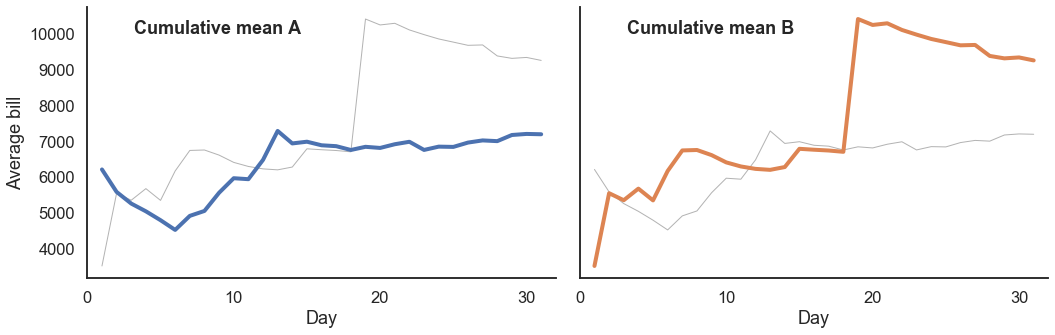

In [73]:
g = sns.relplot(
    data=output,
    y="revenue", x="day", col="group", hue="group",
    kind="line", linewidth=4, zorder=5,
    col_wrap=2, height=5, aspect=1.5, legend=False,
)

for group, ax in g.axes_dict.items():
    ax.text(.1, .90, "Cumulative mean "+str(group), transform=ax.transAxes, fontweight="bold")
    sns.lineplot(
        data=output, x="day", y="revenue", units="group",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

ax.set(xlim=(0, 32))

    
ax.set_xticks(ax.get_xticks()[::2])
g.set_titles("")
g.set_axis_labels("Day", "Average bill")
g.tight_layout()

As suspected, there were large checks that distorted the picture.

#### Graph of the relative change in the cumulative average check of group B to group A.

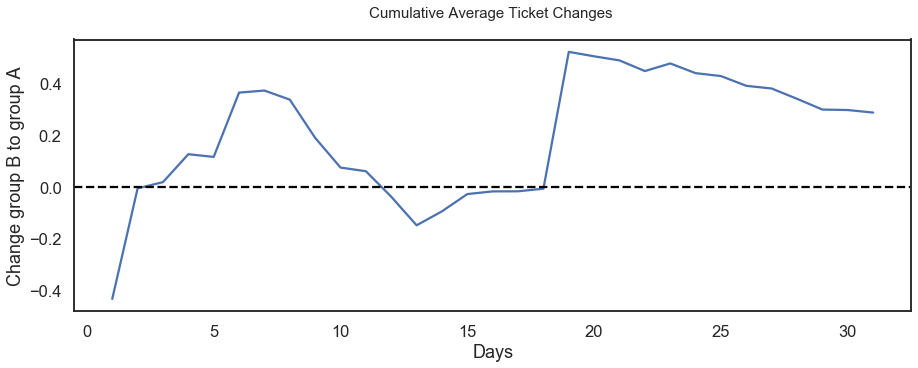

In [77]:
output2 = output.pivot_table(
    index='date', columns='group', values='revenue', aggfunc='mean').reset_index()
output2['change'] = ((output2['B']) / (output2['A']) - 1)

plt.figure(figsize = (15,5)) 

plt.ylim=(-0.5, 0.5)

plt.plot(output2['date'].dt.day,output2['change'] )
plt.axhline(y=0, color='black', linestyle='--') 

plt.title("Cumulative Average Ticket Changes \n", fontsize=15)
plt.ylabel("Change group B to group A")
plt.xlabel("Days")

plt.show()

After the rise of the average in group B, the indicator will decrease. Maybe she's not doing so well.

#### Graph of cumulative conversion by groups. Make inferences and assumptions.

In [78]:
datesGroups = orders[['date', 'group']].drop_duplicates()

# find unique purchases
output = datesGroups.apply(
    lambda x: orders[
        np.logical_and(orders['date'] == x['date'], orders['group'] == x['group'])
    ].agg({'date': 'max','group': 'max','revenue': 'nunique'}),
    axis=1
).sort_values(by=['date', 'group'])

In [79]:
#merge
conversion_data = output.merge(visitors, on = ['date', 'group'])

# make it cumulative
output3 = conversion_data.pivot_table(
    index='date', columns='group', values=['revenue','visitors'], aggfunc='mean')
output3 = output3.cumsum(axis = 0).reset_index()
output3['day'] = output3['date'].dt.day
# calculate conversions
output3['cum_conversion_A'] = output3[( 'revenue', 'A')] / output3[('visitors', 'A')]
output3['cum_conversion_B'] = output3[( 'revenue', 'B')] / output3[('visitors', 'B')]

output3.head()

date revenue     visitors       day cum_conversion_A  \
group                  A   B        A     B                        
0     2019-08-01      22  16      719   713   1             0.03   
1     2019-08-02      40  38     1338  1294   2             0.03   
2     2019-08-03      64  51     1845  1803   3             0.03   
3     2019-08-04      75  65     2562  2573   4             0.03   
4     2019-08-05      97  85     3318  3280   5             0.03   

      cum_conversion_B  
group                   
0                 0.02  
1                 0.03  
2                 0.03  
3                 0.03  
4                 0.03

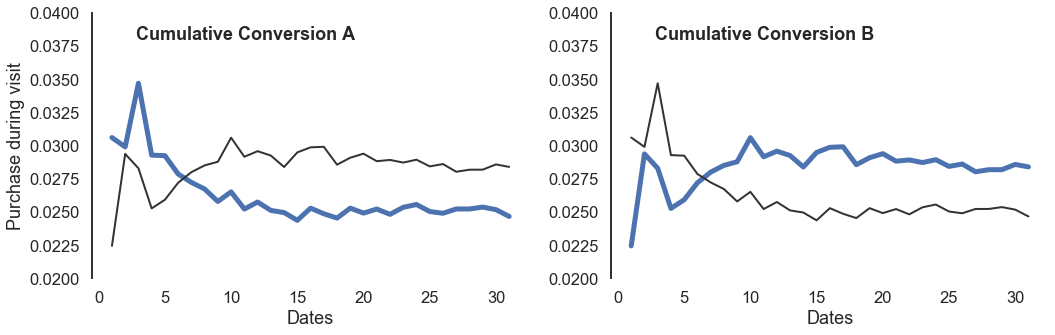

In [80]:
f, (ax1, ax2)=plt.subplots(1, 2, figsize=(15, 5), sharex=True)

ax1.set(ylim=(0.02, 0.04))
ax2.set(ylim=(0.02, 0.04))

#A
ax1.text(.1, .90, "Cumulative Conversion A", transform=ax1.transAxes, fontweight="bold")
sns.lineplot(data=output3, x=output3['day'], y="cum_conversion_A",
             estimator=None,palette="crest", linewidth=5, ax=ax1)
sns.lineplot(data=output3, x=output3['day'], y="cum_conversion_B",
             estimator=None, color=".2", linewidth=2, ax=ax1)

#B
ax2.text(.1, .90, "Cumulative Conversion B", transform=ax2.transAxes, fontweight="bold")
sns.lineplot(data=output3, x=output3['day'], y="cum_conversion_B",
             estimator=None,palette="crest", linewidth=5, ax=ax2)
sns.lineplot(data=output3, x=output3['day'], y="cum_conversion_A",
             estimator=None, color=".2", linewidth=2, ax=ax2)

ax1.set_ylabel("Purchase during visit")
ax2.set_ylabel("")
ax1.set_xlabel("Dates")
ax2.set_xlabel("Dates")


sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

plt.show()

According to this parameter, group B is ahead of A. At the same time, a strong outlier is not visible in the data

#### Graph of the relative change in the cumulative conversion of group B to group A.

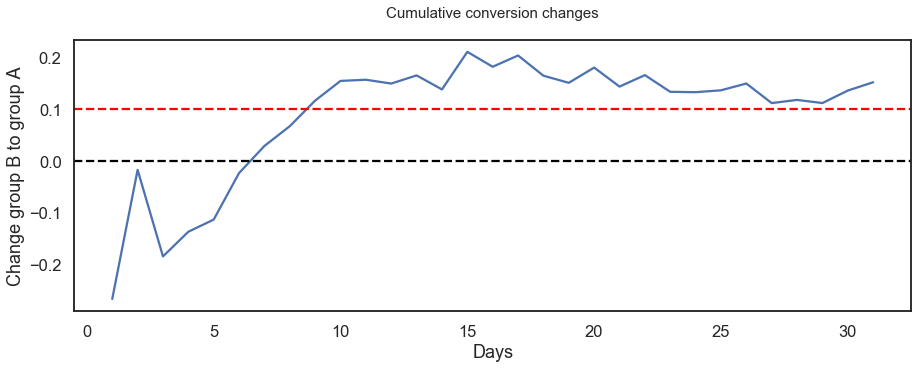

In [82]:
output3['change'] = (output3['cum_conversion_B'] / output3['cum_conversion_A']) - 1

plt.figure(figsize = (15,5)) 
plt.plot(output3['date'].dt.day,output3['change'] )
plt.axhline(y=0, color='black', linestyle='--') 
plt.axhline(y=0.1, color='red', linestyle='--') 

plt.title("Cumulative conversion changes\n", fontsize=15)
plt.ylabel("Change group B to group A")
plt.xlabel("Days")
plt.show()

Positive dynamics is visible for group B. It is necessary to check whether there is a bias among users. Perhaps one visitor made an abnormally large number of orders and this brought down the dynamics

#### Scatter plot of the number of orders by user. Make inferences and assumptions.

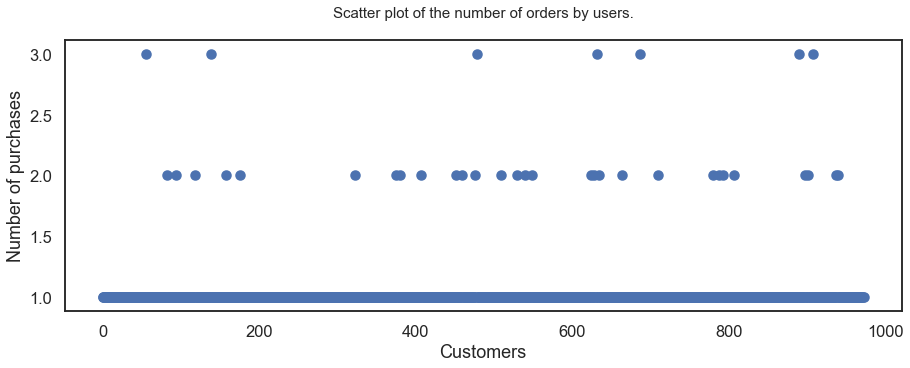

In [86]:
orders_count = orders.pivot_table(index='visitorId', aggfunc='nunique')
x_values = pd.Series(range(0,len(orders_count)))
plt.figure(figsize = (15,5)) 

plt.scatter(x_values, orders_count['transactionId']) 

plt.title("Scatter plot of the number of orders by users.\n", fontsize=15)
plt.ylabel("Number of purchases")
plt.xlabel("Customers")
plt.show()

Most people buy a little. No sharp outbursts. 

#### Calculate the 95th and 99th percentiles of orders per user. Select a boundary to identify anomalous users.

In [87]:
print("Average orders per user:",
    round(orders_count['transactionId'].mean(),2))

Average orders per user: 1.04


In [88]:
print("95, 99 percentiles of orders per user:",
    np.percentile(orders_count['transactionId'], [95, 99]))

95, 99 percentiles of orders per user: [1. 2.]


In [89]:
# let's see how many such people
print("99 percentile includes: ", len(orders_count[orders_count['transactionId'] > 2])/len(orders_count) * 100, "percent")
print("95 percentile includes: ", len(orders_count[orders_count['transactionId'] > 1])/len(orders_count)* 100, 'percent')

99 percentile includes:  0.7194244604316548 percent
95 percentile includes:  3.6998972250770814 percent


No anomalous users found

#### Plot a scatter plot of order values

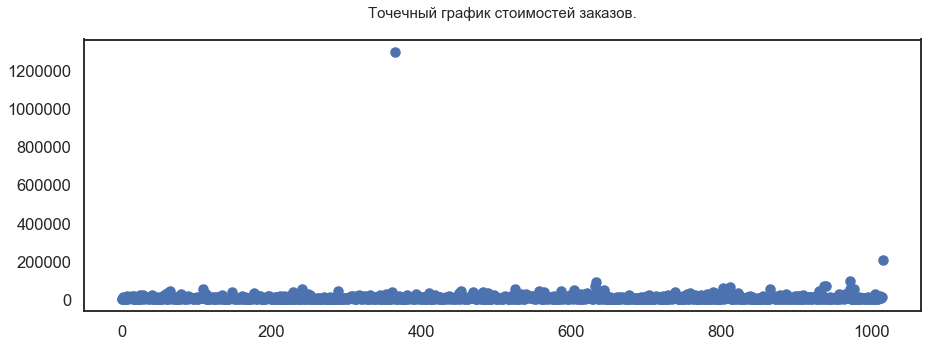

In [90]:
x_values = pd.Series(range(0,len(orders)))
plt.figure(figsize = (15,5)) 

plt.scatter(x_values, orders['revenue']) 

plt.title("Точечный график стоимостей заказов.\n", fontsize=15)
plt.ylabel("")
plt.xlabel("")
plt.show()

There is one, but prohibitively expensive order. There are also smaller orders.

#### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [91]:
print("95, 99 персентили стоимости заказов:",
    np.percentile(orders['revenue'], [95, 99])) 

95, 99 персентили стоимости заказов: [26785. 53904.]


In [92]:
# посмотрим сколько таких людей
print("В 99 персинтиль входит : ", len(orders[orders['revenue'] >= 53904])/len(orders) * 100, "процентов")
print("В 95 персинтиль входит : ", len(orders[orders['revenue'] >= 26785])/len(orders)* 100, 'процентов')

В 99 персинтиль входит :  1.1811023622047243 процентов
В 95 персинтиль входит :  5.019685039370079 процентов


We will consider anomalous users with an order amount of 26785 or more.
This is the 95th percentile of orders per user

#### Statistical significance of differences in conversion between groups on raw data.

We will use Mann-Whitney.

    Null hypothesis H0={the level of the feature in the second sample is not lower than the level of the feature in the first sample};
    The alternative hypothesis is H1={the level of the feature in the second sample is lower than the level of the feature in the first sample}.
    In this case, the first sample is considered to be the one where the value of the attribute is greater.

Hence Null Hypothesis:
* The level of the trait in group A is not lower than the level of the trait in group B.<br>

In [93]:
conversion_data.columns = ['date','group', 'buyers','visitors']
conversion_data['not_buy'] = conversion_data['visitors'] - conversion_data['buyers']
conversion_data['conversion'] = conversion_data['buyers'] / conversion_data['visitors'] 

In [94]:
alpha = 0.05
pvalue = stats.mannwhitneyu(conversion_data[conversion_data['group']=='A']['not_buy'], conversion_data[conversion_data['group']=='B']['not_buy'])[1]

print("p-value:",'{0:.3f}'.format(pvalue))
print("Conversion difference:",'{0:.1f}%'.format(100 * (conversion_data[conversion_data['group']=='B']['conversion'].mean()/conversion_data[conversion_data ['group']=='A']['conversion'].mean()-1)))

if(pvalue<alpha):
    print("We reject the null hypothesis, which means that the level of the conversion feature in sample A is lower than the level of the feature in sample B")
else:
    print("Failed to reject null hypothesis")

p-value: 0.397
Conversion difference: 16.5%
Failed to reject null hypothesis


#### Statistical significance of differences in the average order receipt between groups according to "raw" data.

In [95]:
alpha = 0.05
pvalue = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print("p-value:",'{0:.3f}'.format(pvalue))
print("Difference of average bills:",'{0:.1f}%'.format(100 * (orders[orders['group']=='B']['revenue'].mean()/orders[ orders['group']=='A']['revenue'].mean()-1)))

if(pvalue<alpha):
    print("We reject the null hypothesis, it means that the level of the revenue feature in sample A is lower than the level of the feature in sample B")
else:
    print("Failed to reject null hypothesis")

p-value: 0.415
Difference of average bills: 28.7%
Failed to reject null hypothesis


#### Statistical significance of differences in conversion between groups based on "cleaned" data.

In [96]:
# cleane our data
orders_cl = orders[orders['revenue'] < 26785]

print("len(orders):",len(orders),"len(orders_cl):",len(orders_cl))

len(orders): 1016 len(orders_cl): 965


In [97]:
# recalculating the data.
output = datesGroups.apply(
    lambda x: orders_cl[
        np.logical_and(orders_cl['date'] == x['date'], orders_cl['group'] == x['group'])
    ].agg({'date': 'max','group': 'max','revenue': 'nunique'}),
    axis=1
).sort_values(by=['date', 'group'])

conversion_data = output.merge(visitors,  on = ['date', 'group'])

conversion_data.columns = ['date','group', 'buyers','visitors']
conversion_data['not_buy'] = conversion_data['visitors'] - conversion_data['buyers']
conversion_data['conversion'] = conversion_data['buyers'] / conversion_data['visitors'] 

In [98]:
alpha = 0.05
pvalue = stats.mannwhitneyu(conversion_data[conversion_data['group']=='A']['not_buy'], conversion_data[conversion_data['group']=='B']['not_buy'])[1]

print("p-value:",'{0:.3f}'.format(pvalue))
print("Conversion:",'{0:.1f}%'.format(100 * conversion_data['conversion'].mean()))
print("Conversion difference:",'{0:.1f}%'.format(100 * (conversion_data[conversion_data['group']=='B']['conversion'].mean()/conversion_data[conversion_data ['group']=='A']['conversion'].mean()-1)))

if(pvalue<alpha):
    print("We reject the null hypothesis, which means that the level of the conversion feature in sample A is lower than the level of the feature in sample B")
else:
    print("Failed to reject null hypothesis")

p-value: 0.397
Conversion: 2.6%
Conversion difference: 15.9%
Failed to reject null hypothesis


#### Calculate the statistical significance of the differences in the average order receipt between groups according to the "cleaned" data. 

In [100]:
alpha = 0.05
pvalue = stats.mannwhitneyu(orders_cl[orders_cl['group']=='A']['revenue'], orders_cl[orders_cl['group']=='B']['revenue'])[1]

print("p-value:",'{0:.3f}'.format(pvalue))
print("Average check:", round(orders_cl['revenue'].mean()))
print("Difference of average checks:",'{0:.1f}%'.format(100 * ((orders_cl[orders_cl['group']=='B']['revenue'].mean()/orders_cl [orders_cl['group']=='A']['revenue'].mean())-1)))

if(pvalue<alpha):
    print("We reject the null hypothesis, it means that the level of the revenue feature in sample A is lower than the level of the feature in sample B")
else:
    print("Failed to reject null hypothesis")

p-value: 0.349
Average check: 5035
Difference of average checks: -5.9%
Failed to reject null hypothesis


### Conclusions

On average, a user makes one order per month 1 in the amount of about 5 thousand rubles.
The conversion from visitors to purchases is 2.6%.

Representatives of group B have a different conversion rate than A. Namely, 16.5% more.

However, we cannot consider this difference to be statistically significant.

The difference in average checks between the groups is not large (about 5%).

## Decision based on test results
<a name="3."></a>
[<font size="2">(to content)</font>](#1common.)

***I believe that it is necessary to stop the test, fix the absence of differences between the groups.***

We did not just initially designate the data for 30 days for the test. This time should have been enough to complete the test.

Probably our hypothesis is not powerful enough or there are other important factors that we do not take into account.

Therefore, the most reasonable option is to revise the hypothesis and try to improve it analytically.
It is possible to hold a focus group to understand the insights. For example: Increase the size of the discount or expand the target audience.